In [2]:
import emcee
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import corner
from IPython.display import display, Math
import seaborn as sns
import matplotlib.colors as mcolors

print(emcee.__version__)

3.1.6


In [133]:
# Read the HDF5 file (note: no need to reset the backend here)
#filename = "/scratch/c2042999/chains/mcmc_nDGP_muSigma_PCACuts.h5"
filename = "/scratch/c2042999/chains_final/mcmc_nDGP_muSigma_PCACuts.h5"
#filename = "/home/c2042999/PCA_project/Parameter_inference_nDGP/mcmc/mcmc_nDGP_muSigma_PCACuts_noparam.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain(discard=600, thin=25)
print(f"Current raw chain shape: {raw_chain.shape}")

tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 15794
Current raw chain shape: (607, 76, 12)
Current iteration: 15794
Max 100 x Tau/N: 0.9995254948350327


In [134]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0  # Adjust if needed

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Compute 1σ (68% confidence interval) from the posterior distribution
lower_1sigma, upper_1sigma = np.percentile(raw_chain_flat, [16, 84], axis=0)

print("\nMaximum Likelihood Parameter Values (after burn-in):")
print(max_likelihood_params)

print("\n1σ Confidence Intervals (16th-84th percentile) for each parameter:")
for i, (ml_val, lower, upper) in enumerate(zip(max_likelihood_params, lower_1sigma, upper_1sigma)):
    print(f"{labels[i]}: {ml_val:.6f} (+{upper-ml_val:.6f} / -{ml_val-lower:.6f})")



Maximum Likelihood Parameter Values (after burn-in):
[ 0.27193416  0.25964725 -0.02272258  2.25887521  0.66672514  0.96214002
  0.0223708   1.55160938  1.72208642  1.9010612   2.08671584  2.27536116]

1σ Confidence Intervals (16th-84th percentile) for each parameter:
$\Omega_c$: 0.271934 (+0.003176 / -0.007154)
$\mu_0$: 0.259647 (+0.104255 / -0.070584)
$\Sigma_0$: -0.022723 (+0.045187 / -0.009243)
$10^{9}A_s$: 2.258875 (+0.054570 / -0.125522)
$h$: 0.666725 (+0.017303 / -0.006178)
$n_s$: 0.962140 (+0.004906 / -0.003853)
$\omega_b$: 0.022371 (+0.000170 / -0.000142)
$b_1$: 1.551609 (+0.029962 / -0.015518)
$b_2$: 1.722086 (+0.029676 / -0.015965)
$b_3$: 1.901061 (+0.029384 / -0.016045)
$b_4$: 2.086716 (+0.029264 / -0.017448)
$b_5$: 2.275361 (+0.031714 / -0.018881)


In [68]:
# Define cosmology

cosmo_universe = ccl.Cosmology(Omega_c = 0.269619, 
                          Omega_b = 0.050041,
                          h = 0.6688,
                          n_s = 0.9626,
                          A_s = 2.092e-9)

Bias_distribution_fiducial = np.array([1.562362,
                             1.732963,
                             1.913252,
                             2.100644,
                             2.293210])

In [69]:
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0,0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0], Bias_distribution_fiducial[1],\
         Bias_distribution_fiducial[2],Bias_distribution_fiducial[3],\
         Bias_distribution_fiducial[4]]

lower_value1 = [0.28 - 0.06, -1.5, -1.5, 1.7, 0.61 , 0.92, 0.04, 0.8,0.8,0.8,0.8,0.8]
upper_value1 = [0.36 - 0.04, 1.5, 1.5, 2.5, 0.73,1 , 0.06, 3.0,3.0,3.0,3.0,3.0]



In [74]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
#filename = "/home/c2042999/PCA_project/Parameter_inference_GR/mcmc/mcmc_GR_muSigma_StandardCuts_nofsigma8.h5"
filename = "/scratch/c2042999/chains_final/mcmc_nDGP_muSigma_StandardCuts.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_standardcuts = reader.get_chain(discard=500, thin=20)

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_standardcuts.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 28648
Current raw chain shape: (1407, 76, 12)
Current iteration: 28648
Max 100 x Tau/N: 0.999994153777731


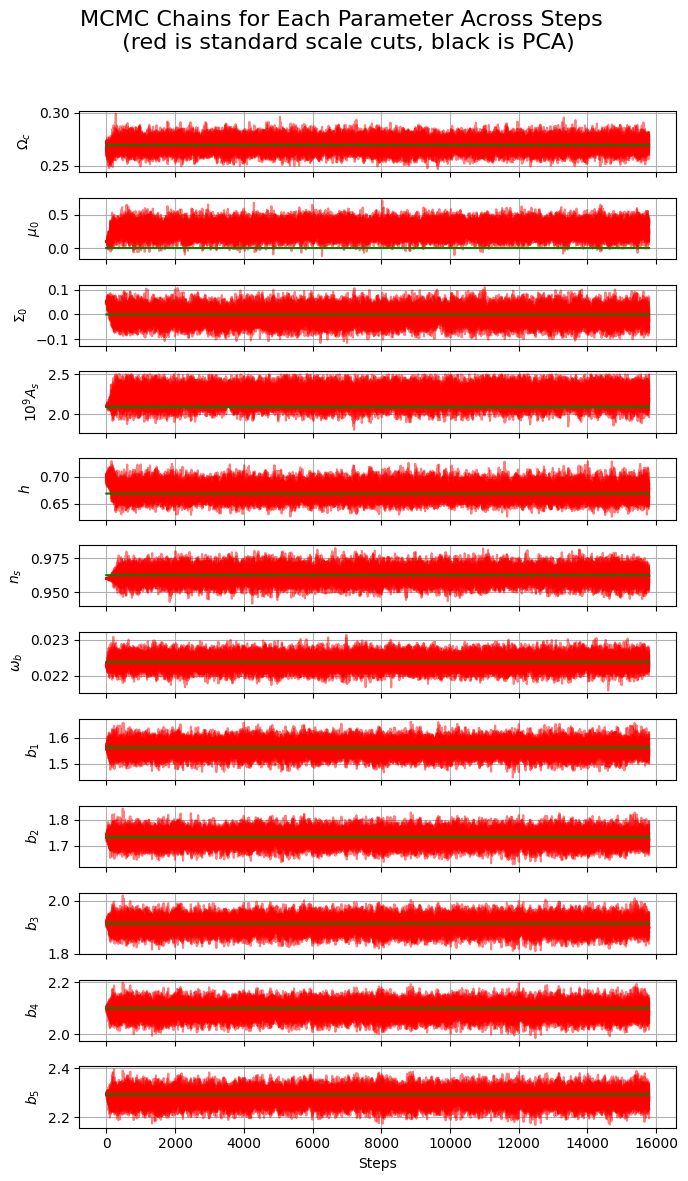

In [75]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(40):
        #ax.plot(raw_chain_standardcuts[:len(raw_chain), j, i], alpha=0.5, color="k")  # Plot for each walker
        ax.plot(raw_chain[:, j, i], alpha=0.5, color="r")  # Plot for each walker
    ax.plot(np.arange(len(raw_chain[:, 0, 0])), value1[i]*np.ones(len(raw_chain[:, 0, 0])), color="g")

    """
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), lower_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    ax.plot(np.arange(len(raw_chain_standardcuts[:, 0, 0])), upper_value1[i]*np.ones(len(raw_chain_standardcuts[:, 0, 0])), color="g", linestyle="--")
    """
    ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps \n (red is standard scale cuts, black is PCA)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig("chains_ESS-C_noparametrization.pdf", bbox_inches='tight')
plt.show()

In [76]:
for i in range(12):
    mcmc = np.percentile(raw_chain[350:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [77]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["CMU Serif", "DejaVu Serif"]
})
col = sns.color_palette("colorblind") 

In [78]:
print(col[0])  # Should output something like (r, g, b) or (r, g, b, a)

(0.00392156862745098, 0.45098039215686275, 0.6980392156862745)


[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.27193416493250244, 0.2596472506280322, -0.022722575199328753, 2.258875210426058, 0.6667251385184052]
(106932, 5)
(1200344, 5)


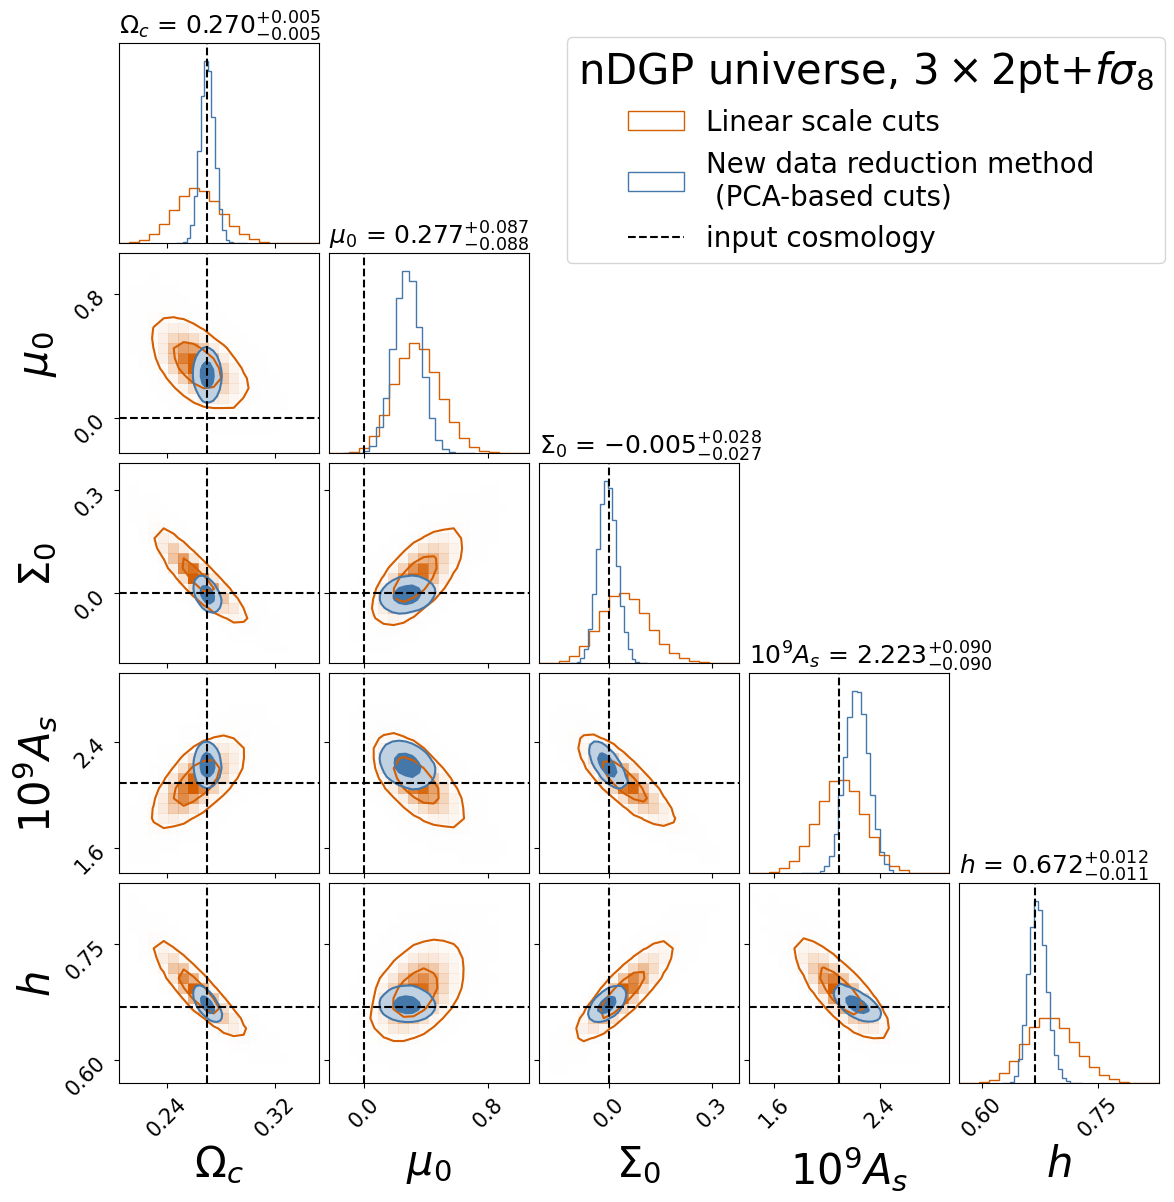

In [79]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = 5#len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################
for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size
 
#plt.legend(["3x2pt, Existing method (linear scale cuts)","maximum likelihood \n (for PCA-based cuts)","3x2pt, Our method (PCA-based cuts)","input cosmology"],\
#           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"GR universe",title_fontsize=60)
plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"nDGP universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_nDGP_marg.pdf", bbox_inches='tight')


[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.27193416493250244, 0.2596472506280322, -0.022722575199328753, 2.258875210426058, 0.6667251385184052]
(106932, 12)
(1200344, 12)


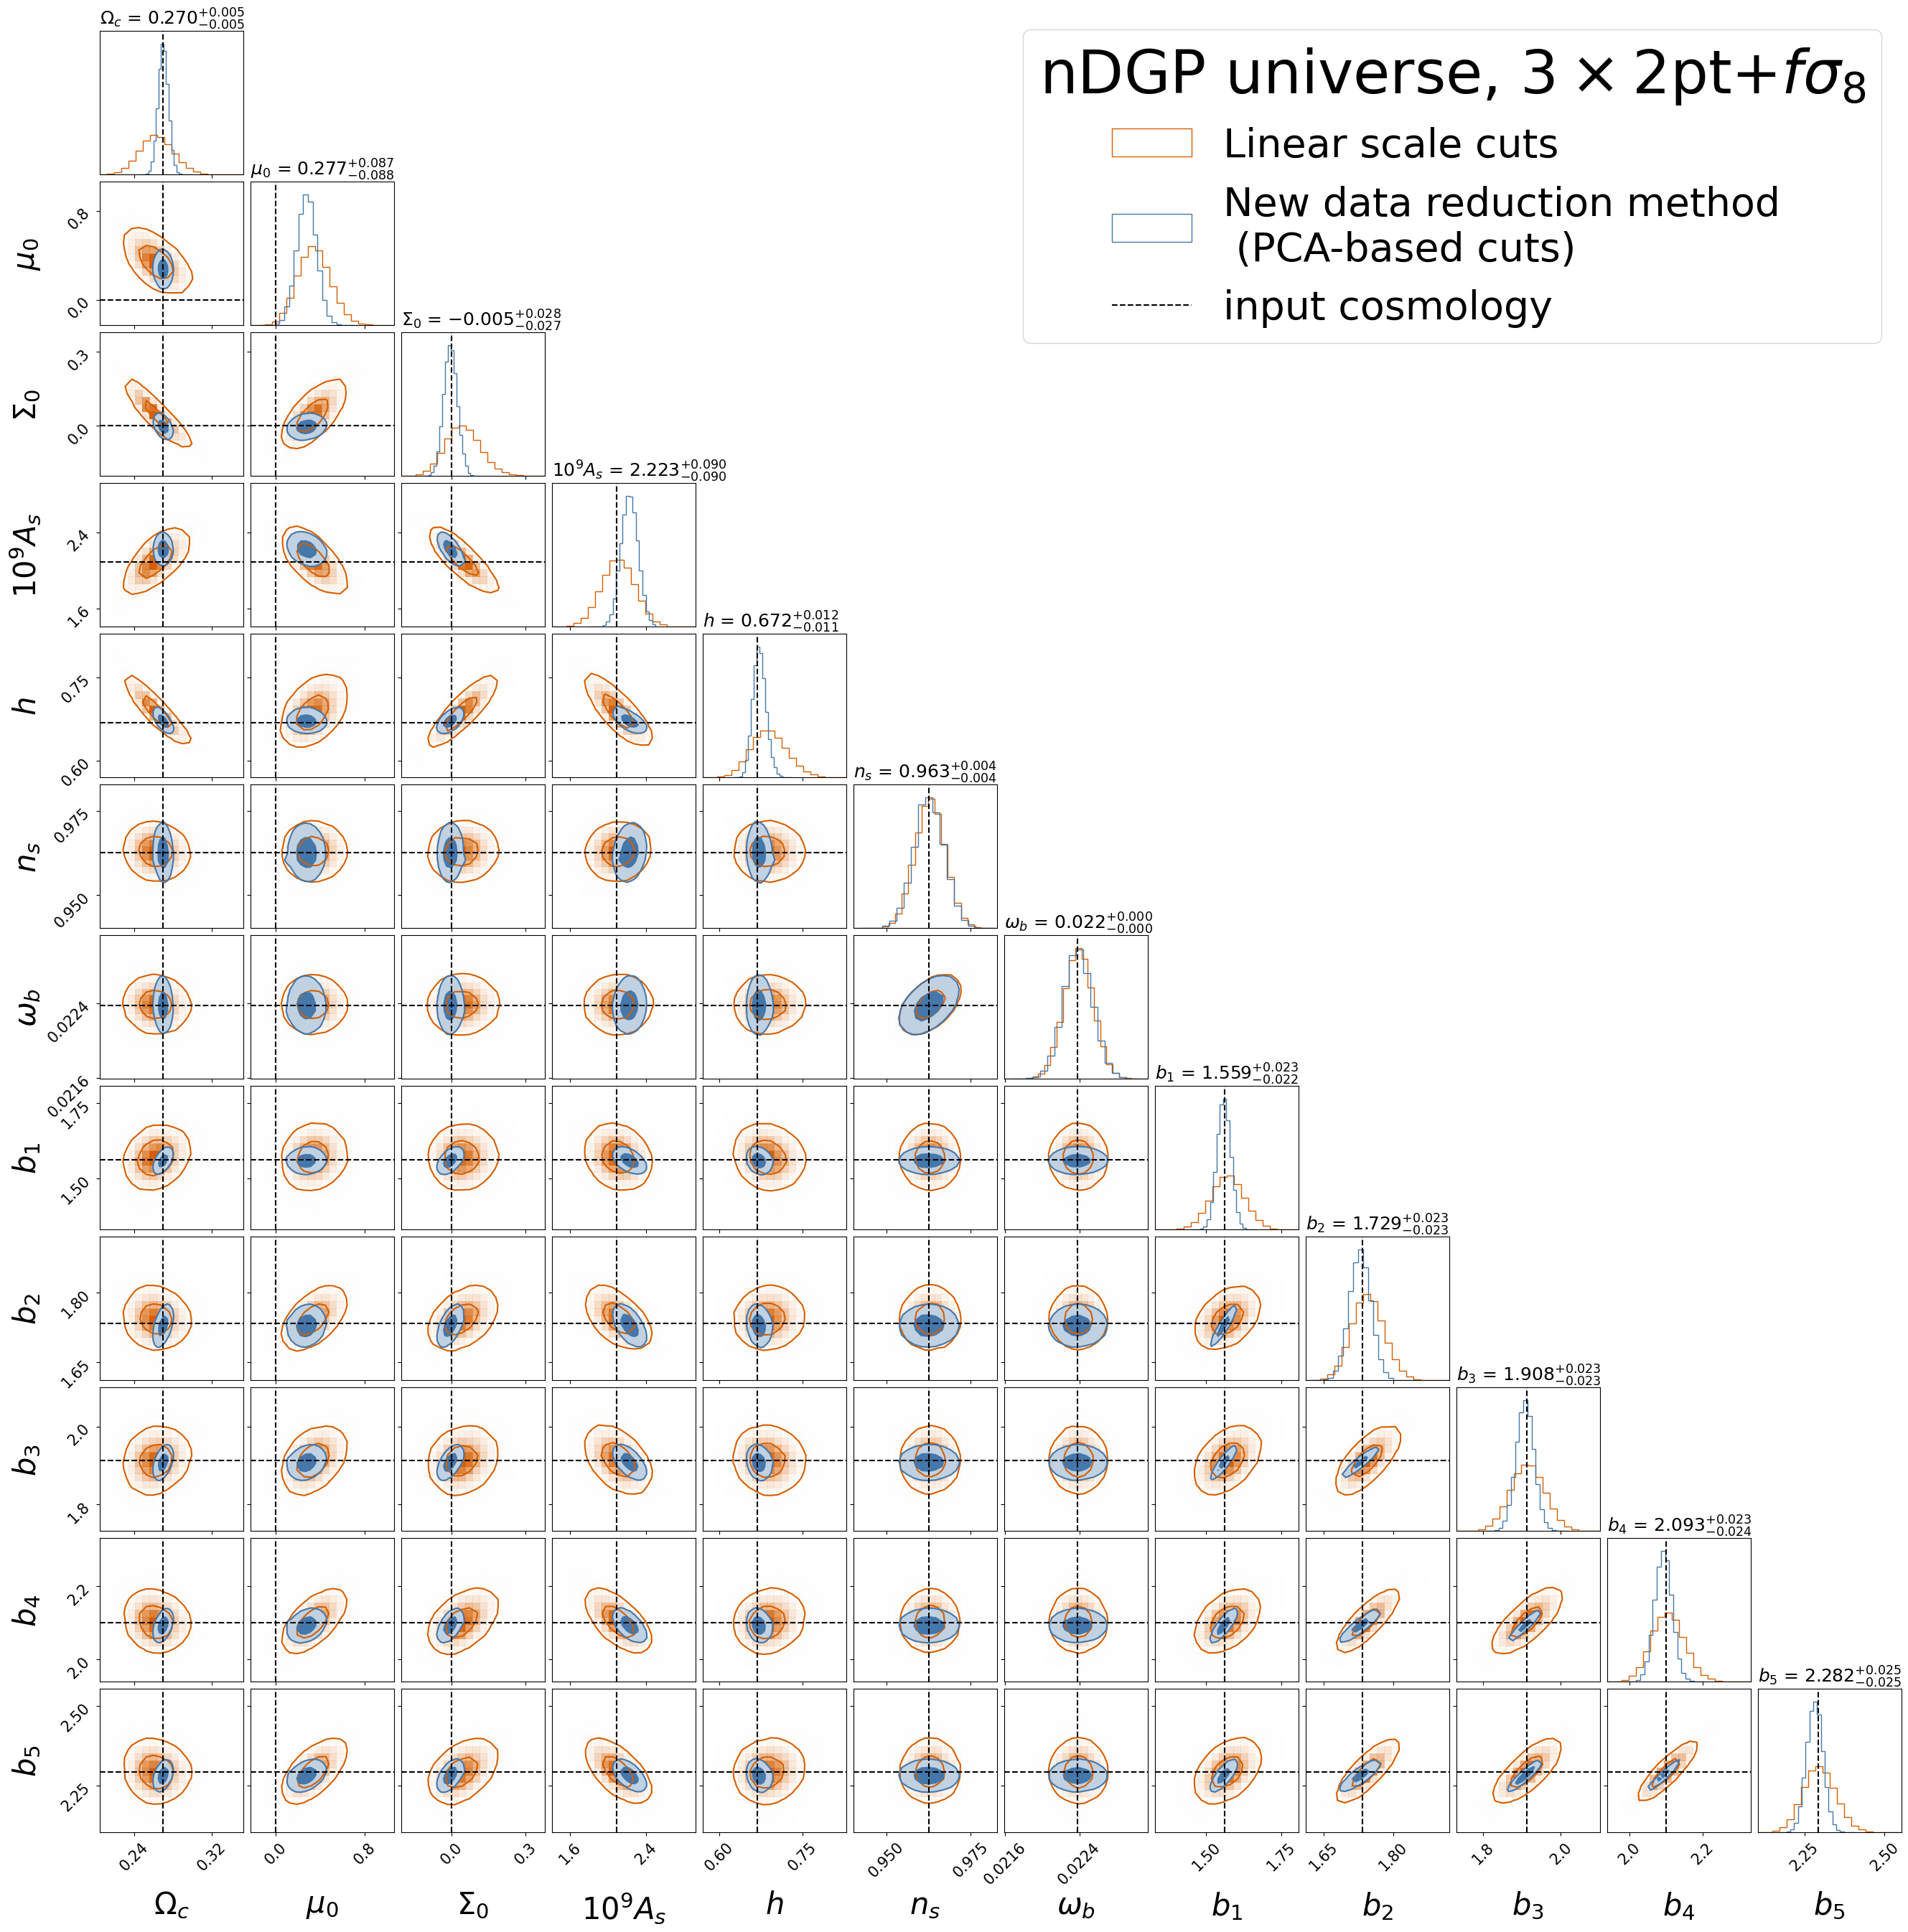

In [80]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = len(labels)
burned_chain = raw_chain_standardcuts

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
len_chain_standardcuts = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    labelpad = 0.1,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################

for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size


plt.legend(["Linear scale cuts","New data reduction method \n (PCA-based cuts)","input cosmology"],\
           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"nDGP universe, $3\times2$pt$+f\sigma_8$",title_fontsize=60)
#plt.legend(["Existing method (linear scale cuts)","Our method (PCA-based cuts)","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"GR universe",title_fontsize=30)
#"maximum likelihood \n (for PCA-based cuts)"
#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_nDGP.pdf", bbox_inches='tight')


## No parametrization

In [129]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
filename = "/home/c2042999/PCA_project/Parameter_inference_nDGP/mcmc/mcmc_nDGP_muSigma_PCACuts_noparam.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

raw_chain_noparam = reader.get_chain(discard=400, thin=20)#discard=500, thin=20

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
print(f"Current raw chain shape: {raw_chain_noparam.shape}")


tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 6433
Current raw chain shape: (301, 80, 12)
Current iteration: 6433
Max 100 x Tau/N: 3.40832539552445


In [130]:
# Get the raw chain and log-probabilities
raw_chain = reader.get_chain(flat=False)  # Unflattened chain: (steps, walkers, parameters)
log_prob = reader.get_log_prob(flat=False)  # Unflattened log-probabilities: (steps, walkers)

# Calculate burn-in index
n_burnin = 0  # Adjust if needed

# Remove the burn-in
raw_chain_burnin_removed = raw_chain[n_burnin:]  # Keep steps after burn-in
log_prob_burnin_removed = log_prob[n_burnin:]  # Keep log-probabilities after burn-in

# Flatten the chains after removing burn-in
raw_chain_flat = raw_chain_burnin_removed.reshape(-1, raw_chain.shape[-1])  # (samples, parameters)
log_prob_flat = log_prob_burnin_removed.reshape(-1)  # (samples,)

# Compute the mean of each parameter
mean_params = np.mean(raw_chain_flat, axis=0)

# Find the sample with the maximum log-probability
max_likelihood_index = np.argmax(log_prob_flat)
max_likelihood_params = raw_chain_flat[max_likelihood_index]

# Compute 1σ (68% confidence interval) from the posterior distribution
lower_1sigma, upper_1sigma = np.percentile(raw_chain_flat, [16, 84], axis=0)

print("\nMaximum Likelihood Parameter Values (after burn-in):")
print(max_likelihood_params)

print("\n1σ Confidence Intervals (16th-84th percentile) for each parameter:")
for i, (ml_val, lower, upper) in enumerate(zip(max_likelihood_params, lower_1sigma, upper_1sigma)):
    print(f"{labels[i]}: {ml_val:.6f} (+{upper-ml_val:.6f} / -{ml_val-lower:.6f})")



Maximum Likelihood Parameter Values (after burn-in):
[ 0.27005964  0.20702485 -0.00708712  2.11570828  0.66926961  0.96351067
  0.02237914  1.55735699  1.72757729  1.9062632   2.09360614  2.28292685]

1σ Confidence Intervals (16th-84th percentile) for each parameter:
$\Omega_c$: 0.270060 (+0.005159 / -0.005298)
$\mu_0$: 0.207025 (+0.416153 / -0.047370)
$\Sigma_0$: -0.007087 (+0.034732 / -0.019308)
$10^{9}A_s$: 2.115708 (+0.040048 / -0.153014)
$h$: 0.669270 (+0.011122 / -0.011472)
$n_s$: 0.963511 (+0.003095 / -0.005490)
$\omega_b$: 0.022379 (+0.000159 / -0.000162)
$b_1$: 1.557357 (+0.028333 / -0.017862)
$b_2$: 1.727577 (+0.028829 / -0.016836)
$b_3$: 1.906263 (+0.031913 / -0.013211)
$b_4$: 2.093606 (+0.035031 / -0.011470)
$b_5$: 2.282927 (+0.043051 / -0.008103)


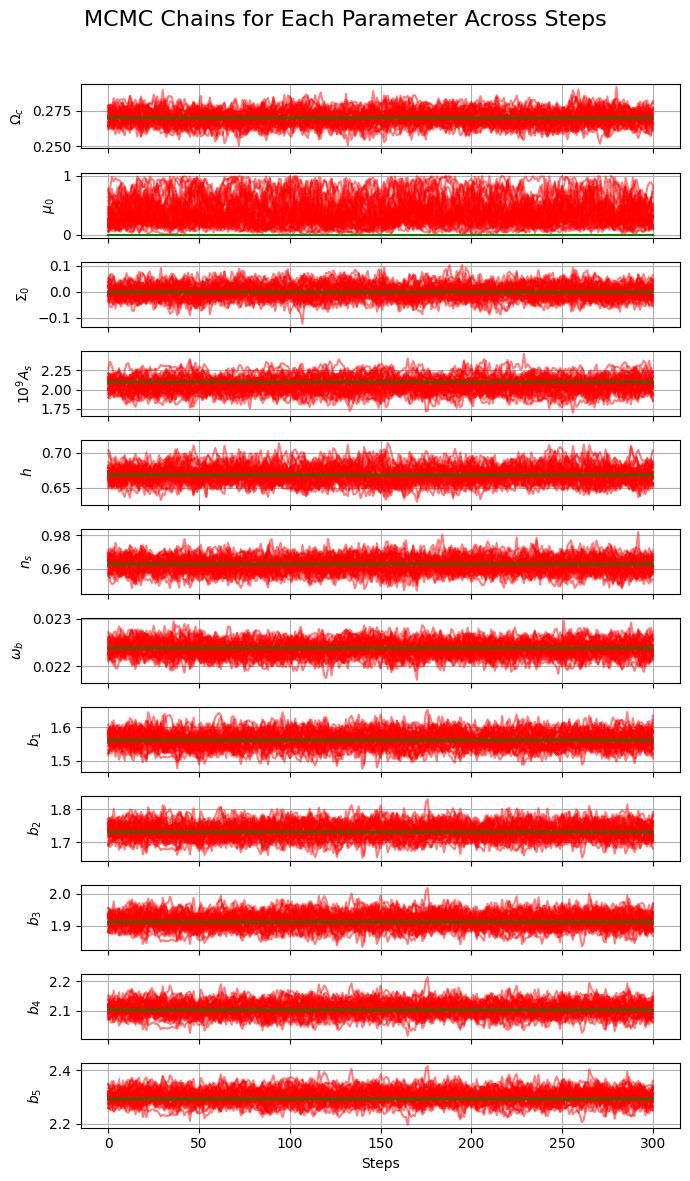

In [122]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain_noparam.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(40):
        ax.plot(raw_chain_noparam[:, j, i], alpha=0.5, color="r")  # Plot for each walker
    ax.plot(np.arange(len(raw_chain_noparam[:, 0, 0])), value1[i]*np.ones(len(raw_chain_noparam[:, 0, 0])), color="g")

    ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
#plt.savefig("chains_ESS-C_noparametrization.pdf", bbox_inches='tight')
plt.show()

[0.269619, 0.0, 0.0, 2.0919999999999996, 0.6688]
[0.27193416493250244, 0.2596472506280322, -0.022722575199328753, 2.258875210426058, 0.6667251385184052]
(24080, 5)
(1200344, 5)


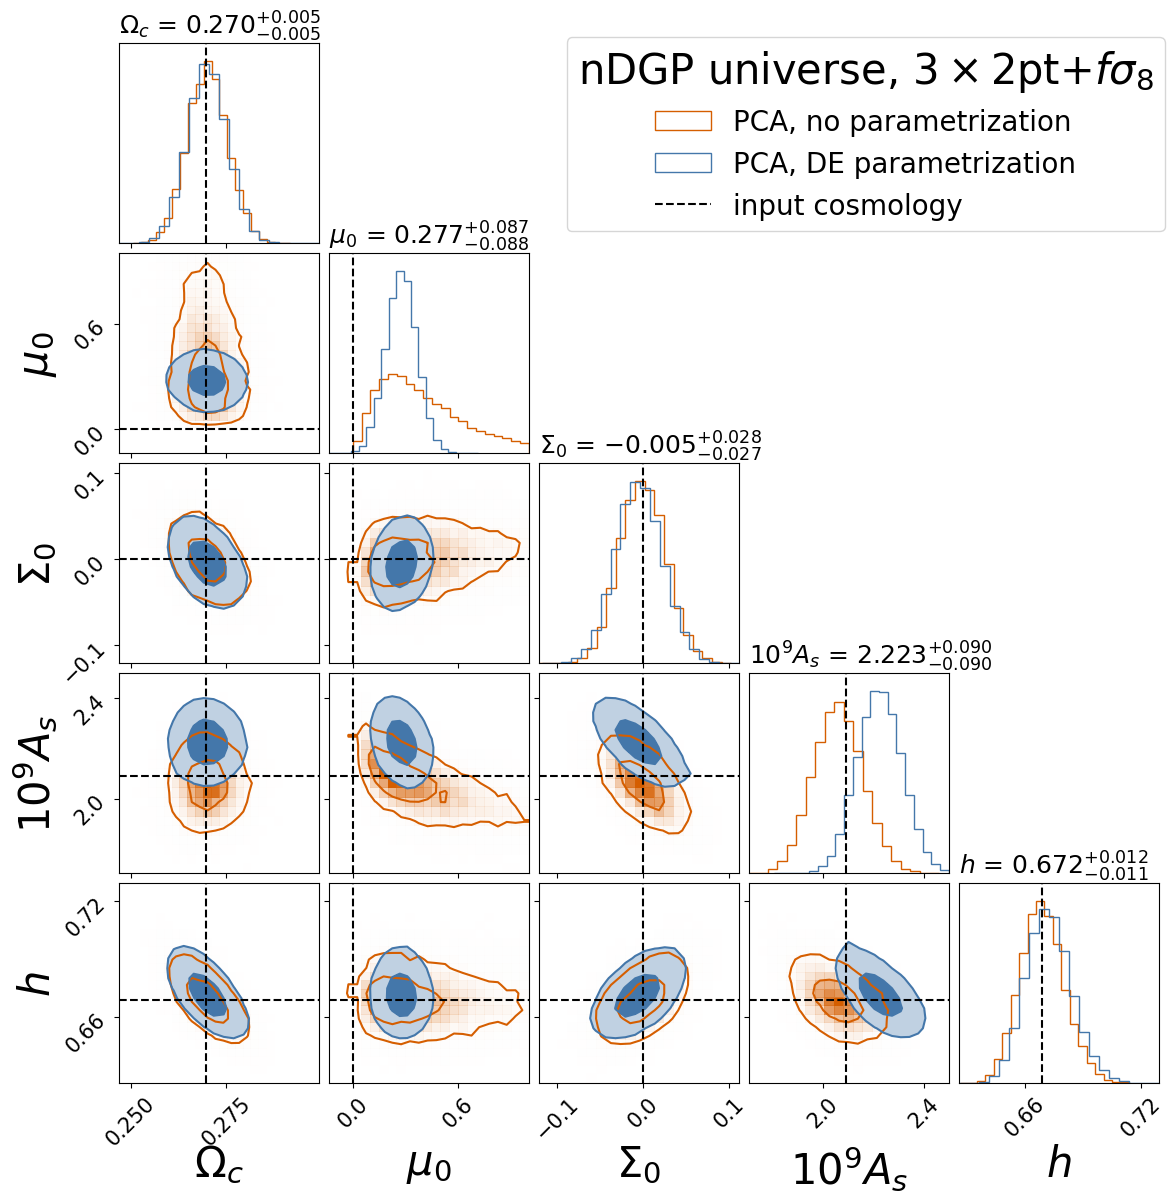

In [123]:
#### STANDARD CUTS #####
print(value1[:ndim])
print(list(max_likelihood_params)[:ndim])
ndim = 5#len(labels)
burned_chain = raw_chain_noparam

colors = ["#4477AA",mcolors.to_hex(col[3])]  # Contour colors
truth_color = "k"  # Truth values

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=14.5),
    show_titles=False,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=False,
    max_n_ticks=2,
    title_fmt=".3f"
)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)
raw_chain_noparam = flat_samples.shape[0]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, color = colors[1],hist_kwargs=dict(density=True)
);

### PCA CUTS####

burned_chain = raw_chain
flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=30),
    title_kwargs=dict(fontsize=18, loc="left"),
    show_titles=True,
    smooth = False,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".3f"
)

print(flat_samples.shape)

corner.corner(
    flat_samples, fig=figure, **CORNER_KWARGS, labels=labels, color=colors[0],hist_kwargs=dict(density=True)
);

######################
# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    if value1[i] != None:
        ax = axes[i, i]
        ax.axvline(value1[i], color=truth_color, linestyle="--")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        if value1[xi] == None:
            ax = axes[yi, xi]
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
        elif value1[yi] == None:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
        else:
            ax = axes[yi, xi]
            ax.axvline(value1[xi], color=truth_color, linestyle="--")
            ax.axhline(value1[yi], color=truth_color, linestyle="--")
########################
for ax in figure.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=15)  # Change label size
 
#plt.legend(["3x2pt, Existing method (linear scale cuts)","maximum likelihood \n (for PCA-based cuts)","3x2pt, Our method (PCA-based cuts)","input cosmology"],\
#           bbox_to_anchor=(1.0, 12.7), fontsize=40,title=r"GR universe",title_fontsize=60)
plt.legend(["PCA, no parametrization","PCA, DE parametrization","input cosmology"], bbox_to_anchor=(1.1, 5.3), fontsize=20,title=r"nDGP universe, $3\times2$pt$+f\sigma_8$",title_fontsize=30)

#plt.savefig("/home/c2042999/PCA_project/Figures/Final_figures/3x2pt_fs8_nDGP_noparamcompare_marg.pdf", bbox_inches='tight')
